# Part 2 - Data Preprocessing and Modeling

This notebook will focus on preprocessing data to bring them optimal size and format using data augmentation parameters. Once the preprocessing complete, I will train various Tensorflow Keras "sequential" and ""convolutional" networks as well as pre-trained models to sample transfer learning to come up with best results. As the classes are imbalanced, my success metrics should be Precision and Recall. Specifically Recall score is the most important as our goal is to focus on minimizing false negative rates to not classify a patient as healthy while in fact they have pneumonia.

In [1]:
# Import libraries

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from glob import glob

from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

import tensorflow as tf

from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, ZeroPadding2D, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, DirectoryIterator
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions

# For reproducibility
np.random.seed(42)

Using TensorFlow backend.


In [2]:
train_dir = './data/chest_xray/train/'
test_dir = './data/chest_xray/test/'

In [3]:
classes = ['normal', 'pneumonia']

I manually checked the images and found that there are a lot of variations for such a small dataset. The hight/width ratio, zooming range, angle of the body etc features differ among differen Xray images. Even the physical dimensions of images are vastly different. This makes it harder to train a model that will give high accuracy rate. I decided to use generator class to generate more images within train data with optimal rotation_range, shear_range, zoom_range, horizontal_flip (mirroring randomly selected images) to get additional observations to train the model with.

In [4]:
# Augmentation configuration to be used while training
train_generator = ImageDataGenerator(
                            rotation_range=20,
                            width_shift_range=0.25,
                            height_shift_range=0.25,
                            rescale=1./255,
                            shear_range=0.25,
                            zoom_range=0.25,
                            horizontal_flip=True,
                            fill_mode='nearest'
                            )

I will resize images to 224x224 px value and turn them to grayscale to only save the brightness and get rid of RGB values as the images are alrady provided as grayscale. It will help the train process run faster.


In [5]:
train_set = DirectoryIterator(train_dir,
                             train_generator,
                             target_size = (224, 224),
                             color_mode = 'rgb',
                             batch_size = 16,
                             classes=classes,
                             class_mode = 'categorical')

Found 5232 images belonging to 2 classes.


In [6]:
# Augmentation configuration to be used for validation
test_generator = ImageDataGenerator(rescale=1./255)

In [7]:
test_set = DirectoryIterator(test_dir,
                             test_generator,
                             target_size = (224, 224),
                             color_mode = 'rgb',
                             batch_size = 16, # set batch size a number that divides sample size
                             classes=classes,
                             class_mode = 'categorical')

Found 624 images belonging to 2 classes.


In [8]:
# Tensor size of train images
train_set.image_shape

(224, 224, 3)

In [9]:
# Tensor size of test images
test_set.image_shape

(224, 224, 3)

In [10]:
train_size = len(train_set.filenames)
test_size = len(test_set.filenames)

In [11]:
train_size, test_size

(5232, 624)

## Model #1 Dense

In [12]:
# Initialize the sequential model
model1 = Sequential()

# Add flatten layer as input layer
model1.add(Flatten(input_shape = train_set.image_shape))

# Add a densely-connected layer with X neurons
model1.add(Dense(units = 32,
                 activation='relu'))

# Add regularization
model1.add(Dropout(rate = 0.30))

# Add a second densely-connected layer with X neurons
model1.add(Dense(units = 256,
                activation='relu'))

# Add a third densely-connected layer with X neurons
model1.add(Dense(units = 512,
                 activation='relu'))

# Add regularization
model1.add(Dropout(rate = 0.10))

# Add a fourth densely-connected layer with X neurons
model1.add(Dense(units = 16,
                 activation='relu'))

# Add output layer
model1.add(Dense(units = 2,
    activation='sigmoid'
))

In [13]:
# Define optimizer
opt = SGD(lr=0.01)

In [14]:
# Compile the first model
model1.compile(optimizer = opt,
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [15]:
# Define early stopping
early_stopping_monitor = EarlyStopping(patience = 5, 
                                       monitor = "val_accuracy", 
                                       mode="max", 
                                       verbose = 2)

# Define batch size (a divisor of test sample size)
batch_size = 16

In [16]:
# Fit model on training data
history = model1.fit_generator(generator = train_set,
                              validation_data = test_set,
                              epochs = 25,
#                               callbacks=[early_stopping_monitor],
                              steps_per_epoch = train_size/batch_size, 
                              validation_steps = test_size/batch_size,
                              shuffle=False,
                              verbose = 2)

Epoch 1/25
327/327 - 152s - loss: 0.5882 - accuracy: 0.7343 - val_loss: 0.6722 - val_accuracy: 0.6250
Epoch 2/25
327/327 - 135s - loss: 0.5655 - accuracy: 0.7422 - val_loss: 0.6621 - val_accuracy: 0.6250
Epoch 3/25
327/327 - 114s - loss: 0.5613 - accuracy: 0.7422 - val_loss: 0.7106 - val_accuracy: 0.6250
Epoch 4/25
327/327 - 98s - loss: 0.5510 - accuracy: 0.7424 - val_loss: 0.6798 - val_accuracy: 0.6250
Epoch 5/25
327/327 - 97s - loss: 0.5452 - accuracy: 0.7427 - val_loss: 0.6528 - val_accuracy: 0.6250
Epoch 6/25
327/327 - 112s - loss: 0.5490 - accuracy: 0.7422 - val_loss: 0.6503 - val_accuracy: 0.6250
Epoch 7/25
327/327 - 97s - loss: 0.5444 - accuracy: 0.7422 - val_loss: 0.6705 - val_accuracy: 0.6250
Epoch 8/25
327/327 - 100s - loss: 0.5347 - accuracy: 0.7422 - val_loss: 0.6508 - val_accuracy: 0.6250
Epoch 9/25
327/327 - 119s - loss: 0.5366 - accuracy: 0.7420 - val_loss: 0.6538 - val_accuracy: 0.6250
Epoch 10/25
327/327 - 97s - loss: 0.5422 - accuracy: 0.7416 - val_loss: 0.6438 - val_

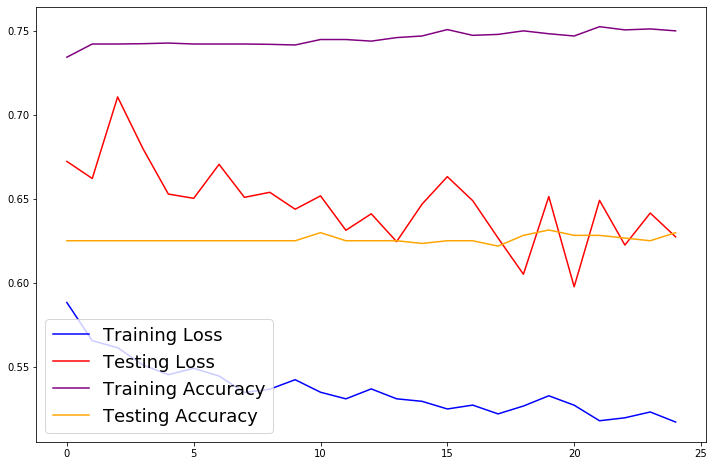

In [17]:
# Check out our train loss & accuracy and test loss & accuracy over epochs.
train_loss = history.history['loss']
test_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']

# Generate line plot of training, testing loss & accuracy over epochs.
plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(test_loss, label='Testing Loss', color='red')
plt.plot(train_accuracy, label='Training Accuracy', color='purple')
plt.plot(test_accuracy, label='Testing Accuracy', color='orange')
plt.legend(fontsize = 18);

In [18]:
predictions = model1.predict_generator(generator = test_set, 
                                       verbose = 2,
                                       steps = test_size/batch_size
                                      )

39/39 - 5s


In [19]:
y_hat = np.argmax(predictions, axis = 1) 
y_true = test_set.classes

In [20]:
len(y_true) == len(y_hat)

True

In [21]:
y_hat

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [22]:
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [23]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

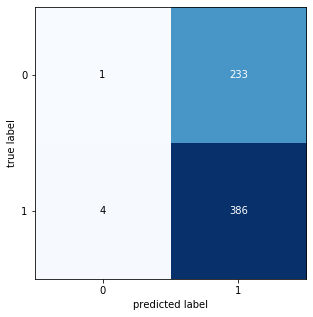

In [24]:
CM = confusion_matrix(y_true, y_hat)
fig, ax = plot_confusion_matrix(conf_mat=CM,  figsize=(5, 5))
plt.show()

In [25]:
true_negative, false_positive, false_negative, true_positive  = CM.ravel()
precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)

print('Precison of chest X-ray for pneumonia:{:.2f}'.format(precision))
print('Recall of chest X-ray for pneumonia:{:.2f}'.format(recall))

Precison of chest X-ray for pneumonia:0.62
Recall of chest X-ray for pneumonia:0.99


## Model #2 Simple CNN

In [26]:
# Initialize the sequential model
model2 = Sequential()

# Add convolution and pooling as input layer
model2.add(Conv2D(filters = 32, # number of filters
                 kernel_size = (3, 3), # height/width of filter
                 input_shape = train_set.image_shape, # shape of input (image)
                 activation = 'relu')) # activation function

model2.add(MaxPooling2D(pool_size = (2, 2))) # dimensions of region of pooling

# Add a second convolutional layer
model2.add(Conv2D(filters = 32, 
                 kernel_size = (3, 3),
                 activation = 'relu'))

model2.add(MaxPooling2D(pool_size = (2, 2)))

# Add a flattening layer
model2.add(Flatten())

# Add a densely-connected layer
model2.add(Dense(units = 128,
                activation = 'relu'))

# Add output layer
model2.add(Dense(units = 2,
                activation = 'sigmoid'))

In [27]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 93312)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               11944064  
_________________________________________________________________
dense_6 (Dense)              (None, 2)                

In [28]:
model2.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [29]:
# Fit model on training data
history = model2.fit_generator(generator = train_set,
                              validation_data = test_set,
                              epochs = 10,
                              callbacks=[early_stopping_monitor],
                              steps_per_epoch = train_size/batch_size, 
                              validation_steps = test_size/batch_size,
                              shuffle = True,
                              verbose = 2)

Epoch 1/10
327/327 - 256s - loss: 0.4650 - accuracy: 0.7874 - val_loss: 0.6564 - val_accuracy: 0.6394
Epoch 2/10
327/327 - 251s - loss: 0.3634 - accuracy: 0.8243 - val_loss: 0.4823 - val_accuracy: 0.7492
Epoch 3/10
327/327 - 251s - loss: 0.3414 - accuracy: 0.8418 - val_loss: 0.5809 - val_accuracy: 0.7364
Epoch 4/10
327/327 - 251s - loss: 0.3245 - accuracy: 0.8475 - val_loss: 0.6218 - val_accuracy: 0.7155
Epoch 5/10
327/327 - 249s - loss: 0.3076 - accuracy: 0.8631 - val_loss: 0.5616 - val_accuracy: 0.7131
Epoch 6/10
327/327 - 249s - loss: 0.2891 - accuracy: 0.8715 - val_loss: 0.5715 - val_accuracy: 0.7492
Epoch 7/10
327/327 - 250s - loss: 0.2789 - accuracy: 0.8793 - val_loss: 0.4240 - val_accuracy: 0.7989
Epoch 8/10
327/327 - 250s - loss: 0.2664 - accuracy: 0.8869 - val_loss: 0.4342 - val_accuracy: 0.7981
Epoch 9/10
327/327 - 251s - loss: 0.2653 - accuracy: 0.8912 - val_loss: 0.3876 - val_accuracy: 0.8237
Epoch 10/10
327/327 - 251s - loss: 0.2455 - accuracy: 0.8902 - val_loss: 0.5398 - 

## Model #3 - Pre-trained Model (VGG16 Convolutional Base)

I decided to use the artichecture of a pre-trained model as I was curious about transfer learning outcome. Transfer learning is using a pre-trained model and/or its weights on a different dataset. I chose to use only the arthitecture of VGG16 convolutional neural network model which is popular from ImageNet competition. This allowed me to save a lot of time testing the performance of my data with an additional model without requiring vast amount of hyperparameter tunning and optimizing.

In [30]:
# base_model = VGG16(weights = 'imagenet', 
#                  include_top = False,
#                  input_shape = train_set.image_shape)

In [31]:
# VGG16 Arthitecture

model = Sequential()
model.add(Conv2D(input_shape=train_set.image_shape, filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=2, activation="sigmoid"))

In [32]:
opt = Adam(lr=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [33]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 56, 56, 256)      

In [34]:
checkpoint = ModelCheckpoint("vgg16.h5", monitor='accuracy', verbose=1, save_best_only=True, 
                             save_weights_only=False, mode='max', save_freq=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')

In [ ]:
history = model.fit_generator(steps_per_epoch=100,
                              generator=train_set, 
                              validation_data=test_set, 
                              validation_steps=10,
                              epochs=25,
                              callbacks=[checkpoint,early])

Epoch 1/25

Epoch 00001: accuracy improved from -inf to 0.62500, saving model to vgg16_1.h5
  1/100 [..............................] - ETA: 1:03:23 - loss: 0.6930 - accuracy: 0.6250
Epoch 00001: accuracy improved from 0.62500 to 0.65625, saving model to vgg16_1.h5
  2/100 [..............................] - ETA: 52:05 - loss: 1.5380 - accuracy: 0.6562  
Epoch 00001: accuracy did not improve from 0.65625
  3/100 [..............................] - ETA: 41:10 - loss: 1.2569 - accuracy: 0.5417
Epoch 00001: accuracy did not improve from 0.65625
  4/100 [>.............................] - ETA: 36:02 - loss: 1.1149 - accuracy: 0.6094
Epoch 00001: accuracy did not improve from 0.65625
  5/100 [>.............................] - ETA: 32:48 - loss: 1.0250 - accuracy: 0.6500
Epoch 00001: accuracy did not improve from 0.65625
  6/100 [>.............................] - ETA: 30:32 - loss: 0.9774 - accuracy: 0.6354
Epoch 00001: accuracy did not improve from 0.65625
  7/100 [=>...........................

 51/100 [==============>...............] - ETA: 13:10 - loss: 0.6259 - accuracy: 0.7279
Epoch 00001: accuracy did not improve from 0.72959
 52/100 [==============>...............] - ETA: 12:52 - loss: 0.6269 - accuracy: 0.7260
Epoch 00001: accuracy did not improve from 0.72959
 53/100 [==============>...............] - ETA: 12:34 - loss: 0.6248 - accuracy: 0.7276
Epoch 00001: accuracy did not improve from 0.72959
 54/100 [===============>..............] - ETA: 12:16 - loss: 0.6257 - accuracy: 0.7257
Epoch 00001: accuracy did not improve from 0.72959
 55/100 [===============>..............] - ETA: 11:58 - loss: 0.6238 - accuracy: 0.7273
Epoch 00001: accuracy improved from 0.72959 to 0.73103, saving model to vgg16_1.h5
 56/100 [===============>..............] - ETA: 11:43 - loss: 0.6200 - accuracy: 0.7310
Epoch 00001: accuracy improved from 0.73103 to 0.73465, saving model to vgg16_1.h5
 57/100 [================>.............] - ETA: 11:28 - loss: 0.6162 - accuracy: 0.7346
Epoch 00001: a

  6/100 [>.............................] - ETA: 21:50 - loss: 0.6107 - accuracy: 0.7083
Epoch 00002: accuracy did not improve from 0.75000
  7/100 [=>............................] - ETA: 21:29 - loss: 0.6138 - accuracy: 0.7054
Epoch 00002: accuracy did not improve from 0.75000
  8/100 [=>............................] - ETA: 21:10 - loss: 0.5992 - accuracy: 0.7188
Epoch 00002: accuracy did not improve from 0.75000
  9/100 [=>............................] - ETA: 20:52 - loss: 0.5952 - accuracy: 0.7222
Epoch 00002: accuracy did not improve from 0.75000
 10/100 [==>...........................] - ETA: 20:36 - loss: 0.5737 - accuracy: 0.7437
Epoch 00002: accuracy did not improve from 0.75000
 11/100 [==>...........................] - ETA: 20:23 - loss: 0.6015 - accuracy: 0.7159
Epoch 00002: accuracy did not improve from 0.75000
 12/100 [==>...........................] - ETA: 20:07 - loss: 0.6034 - accuracy: 0.7135
Epoch 00002: accuracy did not improve from 0.75000
 13/100 [==>...............

 65/100 [==================>...........] - ETA: 7:49 - loss: 0.5793 - accuracy: 0.7365
Epoch 00002: accuracy did not improve from 0.75000
 66/100 [==================>...........] - ETA: 7:36 - loss: 0.5791 - accuracy: 0.7367
Epoch 00002: accuracy did not improve from 0.75000
 67/100 [===================>..........] - ETA: 7:23 - loss: 0.5829 - accuracy: 0.7341
Epoch 00002: accuracy did not improve from 0.75000
 68/100 [===================>..........] - ETA: 7:09 - loss: 0.5837 - accuracy: 0.7335
Epoch 00002: accuracy did not improve from 0.75000
 69/100 [===================>..........] - ETA: 6:59 - loss: 0.5875 - accuracy: 0.7301
Epoch 00002: accuracy did not improve from 0.75000
 70/100 [====================>.........] - ETA: 7:08 - loss: 0.5871 - accuracy: 0.7304
Epoch 00002: accuracy did not improve from 0.75000
 71/100 [====================>.........] - ETA: 7:13 - loss: 0.5868 - accuracy: 0.7306
Epoch 00002: accuracy did not improve from 0.75000
 72/100 [====================>....

 22/100 [=====>........................] - ETA: 1:15:34 - loss: 0.5578 - accuracy: 0.7585
Epoch 00003: accuracy did not improve from 0.77604
 23/100 [=====>........................] - ETA: 1:14:24 - loss: 0.5612 - accuracy: 0.7554
Epoch 00003: accuracy did not improve from 0.77604
 24/100 [======>.......................] - ETA: 1:13:23 - loss: 0.5553 - accuracy: 0.7604
Epoch 00003: accuracy did not improve from 0.77604
 25/100 [======>.......................] - ETA: 1:12:26 - loss: 0.5585 - accuracy: 0.7575
Epoch 00003: accuracy did not improve from 0.77604
 26/100 [======>.......................] - ETA: 1:11:20 - loss: 0.5532 - accuracy: 0.7620
Epoch 00003: accuracy did not improve from 0.77604
 27/100 [=======>......................] - ETA: 1:10:15 - loss: 0.5614 - accuracy: 0.7546
Epoch 00003: accuracy did not improve from 0.77604
 28/100 [=======>......................] - ETA: 1:09:07 - loss: 0.5615 - accuracy: 0.7545
Epoch 00003: accuracy did not improve from 0.77604
 29/100 [====

 81/100 [=======================>......] - ETA: 17:55 - loss: 0.5566 - accuracy: 0.7585
Epoch 00003: accuracy did not improve from 0.77604
 82/100 [=======================>......] - ETA: 16:58 - loss: 0.5568 - accuracy: 0.7584
Epoch 00003: accuracy did not improve from 0.77604
 83/100 [=======================>......] - ETA: 16:01 - loss: 0.5593 - accuracy: 0.7568
Epoch 00003: accuracy did not improve from 0.77604
 84/100 [========================>.....] - ETA: 15:05 - loss: 0.5606 - accuracy: 0.7560
Epoch 00003: accuracy did not improve from 0.77604
 85/100 [========================>.....] - ETA: 14:09 - loss: 0.5576 - accuracy: 0.7581
Epoch 00003: accuracy did not improve from 0.77604
 86/100 [========================>.....] - ETA: 13:12 - loss: 0.5568 - accuracy: 0.7587
Epoch 00003: accuracy did not improve from 0.77604
 87/100 [=========================>....] - ETA: 12:16 - loss: 0.5569 - accuracy: 0.7586
Epoch 00003: accuracy did not improve from 0.77604
 88/100 [==================

 38/100 [==========>...................] - ETA: 58:27 - loss: 0.5613 - accuracy: 0.7533
Epoch 00004: accuracy did not improve from 0.93750
 39/100 [==========>...................] - ETA: 57:30 - loss: 0.5579 - accuracy: 0.7564
Epoch 00004: accuracy did not improve from 0.93750
 40/100 [===========>..................] - ETA: 56:31 - loss: 0.5581 - accuracy: 0.7563
Epoch 00004: accuracy did not improve from 0.93750
 41/100 [===========>..................] - ETA: 55:33 - loss: 0.5598 - accuracy: 0.7546
Epoch 00004: accuracy did not improve from 0.93750
 42/100 [===========>..................] - ETA: 54:34 - loss: 0.5645 - accuracy: 0.7500
Epoch 00004: accuracy did not improve from 0.93750
 43/100 [===========>..................] - ETA: 53:36 - loss: 0.5615 - accuracy: 0.7529
Epoch 00004: accuracy did not improve from 0.93750
 44/100 [============>.................] - ETA: 52:39 - loss: 0.5615 - accuracy: 0.7528
Epoch 00004: accuracy did not improve from 0.93750
 45/100 [============>.....

 97/100 [============================>.] - ETA: 2:47 - loss: 0.5519 - accuracy: 0.7616
Epoch 00004: accuracy did not improve from 0.93750
 98/100 [============================>.] - ETA: 1:52 - loss: 0.5542 - accuracy: 0.7596
Epoch 00004: accuracy did not improve from 0.93750
 99/100 [============================>.] - ETA: 56s - loss: 0.5542 - accuracy: 0.7595 
Epoch 00004: accuracy did not improve from 0.93750
100/100 [==============================] - 5777s 58s/step - loss: 0.5536 - accuracy: 0.7600 - val_loss: 0.6787 - val_accuracy: 0.6438
Epoch 5/25

Epoch 00005: accuracy did not improve from 0.93750
  1/100 [..............................] - ETA: 1:36:28 - loss: 0.5623 - accuracy: 0.7500
Epoch 00005: accuracy did not improve from 0.93750
  2/100 [..............................] - ETA: 1:32:48 - loss: 0.5963 - accuracy: 0.7188
Epoch 00005: accuracy did not improve from 0.93750
  3/100 [..............................] - ETA: 1:30:12 - loss: 0.5403 - accuracy: 0.7708
Epoch 00005: accu

 54/100 [===============>..............] - ETA: 43:19 - loss: 0.5867 - accuracy: 0.7338
Epoch 00005: accuracy did not improve from 0.93750
 55/100 [===============>..............] - ETA: 41:47 - loss: 0.5856 - accuracy: 0.7352
Epoch 00005: accuracy did not improve from 0.93750
 56/100 [===============>..............] - ETA: 40:17 - loss: 0.5855 - accuracy: 0.7355
Epoch 00005: accuracy did not improve from 0.93750
 57/100 [================>.............] - ETA: 38:49 - loss: 0.5861 - accuracy: 0.7346
Epoch 00005: accuracy did not improve from 0.93750
 58/100 [================>.............] - ETA: 37:24 - loss: 0.5843 - accuracy: 0.7371
Epoch 00005: accuracy did not improve from 0.93750
 59/100 [================>.............] - ETA: 36:02 - loss: 0.5827 - accuracy: 0.7394
Epoch 00005: accuracy did not improve from 0.93750
 60/100 [=================>............] - ETA: 34:41 - loss: 0.5848 - accuracy: 0.7365
Epoch 00005: accuracy did not improve from 0.93750
 61/100 [=================>

 11/100 [==>...........................] - ETA: 19:24 - loss: 0.5977 - accuracy: 0.7216
Epoch 00006: accuracy did not improve from 0.93750
 12/100 [==>...........................] - ETA: 19:10 - loss: 0.6063 - accuracy: 0.7135
Epoch 00006: accuracy did not improve from 0.93750
 13/100 [==>...........................] - ETA: 18:59 - loss: 0.6236 - accuracy: 0.6971
Epoch 00006: accuracy did not improve from 0.93750
 14/100 [===>..........................] - ETA: 18:46 - loss: 0.6239 - accuracy: 0.6964
Epoch 00006: accuracy did not improve from 0.93750
 15/100 [===>..........................] - ETA: 18:31 - loss: 0.6240 - accuracy: 0.6958
Epoch 00006: accuracy did not improve from 0.93750
 16/100 [===>..........................] - ETA: 18:18 - loss: 0.6165 - accuracy: 0.7031
Epoch 00006: accuracy did not improve from 0.93750
 17/100 [====>.........................] - ETA: 18:03 - loss: 0.6134 - accuracy: 0.7059
Epoch 00006: accuracy did not improve from 0.93750
 18/100 [====>.............

 70/100 [====================>.........] - ETA: 6:31 - loss: 0.5953 - accuracy: 0.7205
Epoch 00006: accuracy did not improve from 0.93750
 71/100 [====================>.........] - ETA: 6:17 - loss: 0.5965 - accuracy: 0.7192
Epoch 00006: accuracy did not improve from 0.93750
 72/100 [====================>.........] - ETA: 6:04 - loss: 0.5953 - accuracy: 0.7205
Epoch 00006: accuracy did not improve from 0.93750
 73/100 [====================>.........] - ETA: 5:51 - loss: 0.5932 - accuracy: 0.7226
Epoch 00006: accuracy did not improve from 0.93750
 74/100 [=====================>........] - ETA: 5:38 - loss: 0.5928 - accuracy: 0.7230
Epoch 00006: accuracy did not improve from 0.93750
 75/100 [=====================>........] - ETA: 5:25 - loss: 0.5925 - accuracy: 0.7233
Epoch 00006: accuracy did not improve from 0.93750
 76/100 [=====================>........] - ETA: 5:12 - loss: 0.5921 - accuracy: 0.7237
Epoch 00006: accuracy did not improve from 0.93750
 77/100 [======================>..

 28/100 [=======>......................] - ETA: 16:12 - loss: 0.5723 - accuracy: 0.7433
Epoch 00007: accuracy did not improve from 0.93750
 29/100 [=======>......................] - ETA: 15:59 - loss: 0.5698 - accuracy: 0.7457
Epoch 00007: accuracy did not improve from 0.93750
 30/100 [========>.....................] - ETA: 15:46 - loss: 0.5737 - accuracy: 0.7417
Epoch 00007: accuracy did not improve from 0.93750
 31/100 [========>.....................] - ETA: 15:33 - loss: 0.5714 - accuracy: 0.7440
Epoch 00007: accuracy did not improve from 0.93750
 32/100 [========>.....................] - ETA: 15:19 - loss: 0.5712 - accuracy: 0.7441
Epoch 00007: accuracy did not improve from 0.93750
 33/100 [========>.....................] - ETA: 15:05 - loss: 0.5746 - accuracy: 0.7405
Epoch 00007: accuracy did not improve from 0.93750
 34/100 [=========>....................] - ETA: 14:51 - loss: 0.5726 - accuracy: 0.7426
Epoch 00007: accuracy did not improve from 0.93750
 35/100 [=========>........

 87/100 [=========================>....] - ETA: 2:54 - loss: 0.5810 - accuracy: 0.7342
Epoch 00007: accuracy did not improve from 0.93750
 88/100 [=========================>....] - ETA: 2:41 - loss: 0.5802 - accuracy: 0.7351
Epoch 00007: accuracy did not improve from 0.93750
 89/100 [=========================>....] - ETA: 2:27 - loss: 0.5787 - accuracy: 0.7367
Epoch 00007: accuracy did not improve from 0.93750
 90/100 [==========================>...] - ETA: 2:14 - loss: 0.5786 - accuracy: 0.7368
Epoch 00007: accuracy did not improve from 0.93750
 91/100 [==========================>...] - ETA: 2:01 - loss: 0.5778 - accuracy: 0.7376
Epoch 00007: accuracy did not improve from 0.93750
 92/100 [==========================>...] - ETA: 1:47 - loss: 0.5789 - accuracy: 0.7364
Epoch 00007: accuracy did not improve from 0.93750
 93/100 [==========================>...] - ETA: 1:34 - loss: 0.5788 - accuracy: 0.7366
Epoch 00007: accuracy did not improve from 0.93750
 94/100 [=========================

 44/100 [============>.................] - ETA: 12:34 - loss: 0.5703 - accuracy: 0.7443
Epoch 00008: accuracy did not improve from 0.93750
 45/100 [============>.................] - ETA: 12:20 - loss: 0.5687 - accuracy: 0.7458
Epoch 00008: accuracy did not improve from 0.93750
 46/100 [============>.................] - ETA: 12:06 - loss: 0.5671 - accuracy: 0.7473
Epoch 00008: accuracy did not improve from 0.93750
 47/100 [=============>................] - ETA: 11:53 - loss: 0.5642 - accuracy: 0.7500
Epoch 00008: accuracy did not improve from 0.93750
 48/100 [=============>................] - ETA: 11:40 - loss: 0.5628 - accuracy: 0.7513
Epoch 00008: accuracy did not improve from 0.93750
 49/100 [=============>................] - ETA: 11:26 - loss: 0.5628 - accuracy: 0.7513
Epoch 00008: accuracy did not improve from 0.93750
 50/100 [==============>...............] - ETA: 11:12 - loss: 0.5654 - accuracy: 0.7487
Epoch 00008: accuracy did not improve from 0.93750
 51/100 [==============>...

  2/100 [..............................] - ETA: 26:23 - loss: 0.3296 - accuracy: 0.9688
Epoch 00009: accuracy did not improve from 0.96875
  3/100 [..............................] - ETA: 24:24 - loss: 0.3847 - accuracy: 0.9167
Epoch 00009: accuracy did not improve from 0.96875
  4/100 [>.............................] - ETA: 23:30 - loss: 0.4119 - accuracy: 0.8906
Epoch 00009: accuracy did not improve from 0.96875
  5/100 [>.............................] - ETA: 22:51 - loss: 0.4420 - accuracy: 0.8625
Epoch 00009: accuracy did not improve from 0.96875
  6/100 [>.............................] - ETA: 22:24 - loss: 0.4383 - accuracy: 0.8646
Epoch 00009: accuracy did not improve from 0.96875
  7/100 [=>............................] - ETA: 22:01 - loss: 0.4665 - accuracy: 0.8393
Epoch 00009: accuracy did not improve from 0.96875
  8/100 [=>............................] - ETA: 21:37 - loss: 0.4785 - accuracy: 0.8281
Epoch 00009: accuracy did not improve from 0.96875
  9/100 [=>................

 61/100 [=================>............] - ETA: 8:47 - loss: 0.5666 - accuracy: 0.7469
Epoch 00009: accuracy did not improve from 0.96875
 62/100 [=================>............] - ETA: 8:34 - loss: 0.5656 - accuracy: 0.7480
Epoch 00009: accuracy did not improve from 0.96875
 63/100 [=================>............] - ETA: 8:20 - loss: 0.5695 - accuracy: 0.7440
Epoch 00009: accuracy did not improve from 0.96875
 64/100 [==================>...........] - ETA: 8:06 - loss: 0.5704 - accuracy: 0.7432
Epoch 00009: accuracy did not improve from 0.96875
 65/100 [==================>...........] - ETA: 7:53 - loss: 0.5693 - accuracy: 0.7442
Epoch 00009: accuracy did not improve from 0.96875
 66/100 [==================>...........] - ETA: 7:39 - loss: 0.5729 - accuracy: 0.7405
Epoch 00009: accuracy did not improve from 0.96875
 67/100 [===================>..........] - ETA: 7:26 - loss: 0.5728 - accuracy: 0.7407
Epoch 00009: accuracy did not improve from 0.96875
 68/100 [===================>.....

 19/100 [====>.........................] - ETA: 18:21 - loss: 0.6101 - accuracy: 0.7072
Epoch 00010: accuracy did not improve from 0.96875
 20/100 [=====>........................] - ETA: 18:59 - loss: 0.6109 - accuracy: 0.7063
Epoch 00010: accuracy did not improve from 0.96875
 21/100 [=====>........................] - ETA: 20:15 - loss: 0.6176 - accuracy: 0.6994
Epoch 00010: accuracy did not improve from 0.96875
 22/100 [=====>........................] - ETA: 23:24 - loss: 0.6096 - accuracy: 0.7074
Epoch 00010: accuracy did not improve from 0.96875
 23/100 [=====>........................] - ETA: 25:59 - loss: 0.6076 - accuracy: 0.7092
Epoch 00010: accuracy did not improve from 0.96875
 24/100 [======>.......................] - ETA: 27:58 - loss: 0.6008 - accuracy: 0.7161
Epoch 00010: accuracy did not improve from 0.96875
 25/100 [======>.......................] - ETA: 29:59 - loss: 0.5947 - accuracy: 0.7225
Epoch 00010: accuracy did not improve from 0.96875
 26/100 [======>...........

 78/100 [======================>.......] - ETA: 13:28 - loss: 0.5624 - accuracy: 0.7516
Epoch 00010: accuracy did not improve from 0.96875
 79/100 [======================>.......] - ETA: 12:46 - loss: 0.5614 - accuracy: 0.7524
Epoch 00010: accuracy did not improve from 0.96875
 80/100 [=======================>......] - ETA: 12:05 - loss: 0.5614 - accuracy: 0.7523
Epoch 00010: accuracy did not improve from 0.96875
 81/100 [=======================>......] - ETA: 11:25 - loss: 0.5624 - accuracy: 0.7515
Epoch 00010: accuracy did not improve from 0.96875
 82/100 [=======================>......] - ETA: 10:45 - loss: 0.5633 - accuracy: 0.7508
Epoch 00010: accuracy did not improve from 0.96875
 83/100 [=======================>......] - ETA: 10:05 - loss: 0.5633 - accuracy: 0.7508
Epoch 00010: accuracy did not improve from 0.96875
 84/100 [========================>.....] - ETA: 9:26 - loss: 0.5632 - accuracy: 0.7507 
Epoch 00010: accuracy did not improve from 0.96875
 85/100 [==================

 35/100 [=========>....................] - ETA: 19:25 - loss: 0.5480 - accuracy: 0.7679
Epoch 00011: accuracy did not improve from 0.96875
 36/100 [=========>....................] - ETA: 19:06 - loss: 0.5443 - accuracy: 0.7708
Epoch 00011: accuracy did not improve from 0.96875
 37/100 [==========>...................] - ETA: 18:51 - loss: 0.5448 - accuracy: 0.7703
Epoch 00011: accuracy did not improve from 0.96875
 38/100 [==========>...................] - ETA: 18:32 - loss: 0.5453 - accuracy: 0.7697
Epoch 00011: accuracy did not improve from 0.96875
 39/100 [==========>...................] - ETA: 18:14 - loss: 0.5498 - accuracy: 0.7660
Epoch 00011: accuracy did not improve from 0.96875
 40/100 [===========>..................] - ETA: 17:59 - loss: 0.5443 - accuracy: 0.7703
Epoch 00011: accuracy did not improve from 0.96875
 41/100 [===========>..................] - ETA: 17:43 - loss: 0.5410 - accuracy: 0.7729
Epoch 00011: accuracy did not improve from 0.96875
 42/100 [===========>......

 94/100 [===========================>..] - ETA: 1:51 - loss: 0.5522 - accuracy: 0.7620
Epoch 00011: accuracy did not improve from 0.96875
 95/100 [===========================>..] - ETA: 1:33 - loss: 0.5537 - accuracy: 0.7605
Epoch 00011: accuracy did not improve from 0.96875
 96/100 [===========================>..] - ETA: 1:14 - loss: 0.5538 - accuracy: 0.7604
Epoch 00011: accuracy did not improve from 0.96875
 97/100 [============================>.] - ETA: 55s - loss: 0.5539 - accuracy: 0.7603 
Epoch 00011: accuracy did not improve from 0.96875
 98/100 [============================>.] - ETA: 37s - loss: 0.5553 - accuracy: 0.7589
Epoch 00011: accuracy did not improve from 0.96875
 99/100 [============================>.] - ETA: 18s - loss: 0.5567 - accuracy: 0.7576
Epoch 00011: accuracy did not improve from 0.96875
100/100 [==============================] - 1923s 19s/step - loss: 0.5542 - accuracy: 0.7600 - val_loss: 0.6712 - val_accuracy: 0.6438
Epoch 12/25

Epoch 00012: accuracy did n

 51/100 [==============>...............] - ETA: 16:02 - loss: 0.5636 - accuracy: 0.7500
Epoch 00012: accuracy did not improve from 0.96875
 52/100 [==============>...............] - ETA: 15:42 - loss: 0.5648 - accuracy: 0.7488
Epoch 00012: accuracy did not improve from 0.96875
 53/100 [==============>...............] - ETA: 15:21 - loss: 0.5672 - accuracy: 0.7465
Epoch 00012: accuracy did not improve from 0.96875
 54/100 [===============>..............] - ETA: 15:00 - loss: 0.5719 - accuracy: 0.7419
Epoch 00012: accuracy did not improve from 0.96875
 55/100 [===============>..............] - ETA: 14:45 - loss: 0.5729 - accuracy: 0.7409
Epoch 00012: accuracy did not improve from 0.96875
 56/100 [===============>..............] - ETA: 14:23 - loss: 0.5716 - accuracy: 0.7422
Epoch 00012: accuracy did not improve from 0.96875
 57/100 [================>.............] - ETA: 14:02 - loss: 0.5715 - accuracy: 0.7423
Epoch 00012: accuracy did not improve from 0.96875
 58/100 [================>.

  9/100 [=>............................] - ETA: 30:07 - loss: 0.5463 - accuracy: 0.7708
Epoch 00013: accuracy did not improve from 0.96875
 10/100 [==>...........................] - ETA: 29:46 - loss: 0.5422 - accuracy: 0.7750
Epoch 00013: accuracy did not improve from 0.96875
 11/100 [==>...........................] - ETA: 29:27 - loss: 0.5661 - accuracy: 0.7500
Epoch 00013: accuracy did not improve from 0.96875
 12/100 [==>...........................] - ETA: 29:09 - loss: 0.5558 - accuracy: 0.7604
Epoch 00013: accuracy did not improve from 0.96875
 13/100 [==>...........................] - ETA: 28:48 - loss: 0.5470 - accuracy: 0.7692
Epoch 00013: accuracy did not improve from 0.96875
 14/100 [===>..........................] - ETA: 28:28 - loss: 0.5394 - accuracy: 0.7768
Epoch 00013: accuracy did not improve from 0.96875
 15/100 [===>..........................] - ETA: 28:08 - loss: 0.5410 - accuracy: 0.7750
Epoch 00013: accuracy did not improve from 0.96875
 16/100 [===>..............

 68/100 [===================>..........] - ETA: 11:21 - loss: 0.5560 - accuracy: 0.7583
Epoch 00013: accuracy did not improve from 0.96875
 69/100 [===================>..........] - ETA: 11:01 - loss: 0.5561 - accuracy: 0.7582
Epoch 00013: accuracy did not improve from 0.96875
 70/100 [====================>.........] - ETA: 10:40 - loss: 0.5562 - accuracy: 0.7580
Epoch 00013: accuracy did not improve from 0.96875
 71/100 [====================>.........] - ETA: 10:18 - loss: 0.5572 - accuracy: 0.7570
Epoch 00013: accuracy did not improve from 0.96875
 72/100 [====================>.........] - ETA: 9:57 - loss: 0.5582 - accuracy: 0.7561 
Epoch 00013: accuracy did not improve from 0.96875
 73/100 [====================>.........] - ETA: 9:35 - loss: 0.5564 - accuracy: 0.7577
Epoch 00013: accuracy did not improve from 0.96875
 74/100 [=====================>........] - ETA: 9:13 - loss: 0.5592 - accuracy: 0.7551
Epoch 00013: accuracy did not improve from 0.96875
 75/100 [====================

 26/100 [======>.......................] - ETA: 23:13 - loss: 0.5836 - accuracy: 0.7308
Epoch 00014: accuracy did not improve from 0.96875
 27/100 [=======>......................] - ETA: 22:54 - loss: 0.5763 - accuracy: 0.7384
Epoch 00014: accuracy did not improve from 0.96875
 28/100 [=======>......................] - ETA: 22:35 - loss: 0.5801 - accuracy: 0.7344
Epoch 00014: accuracy did not improve from 0.96875
 29/100 [=======>......................] - ETA: 22:14 - loss: 0.5754 - accuracy: 0.7392
Epoch 00014: accuracy did not improve from 0.96875
 30/100 [========>.....................] - ETA: 21:54 - loss: 0.5750 - accuracy: 0.7396
Epoch 00014: accuracy did not improve from 0.96875
 31/100 [========>.....................] - ETA: 21:34 - loss: 0.5746 - accuracy: 0.7399
Epoch 00014: accuracy did not improve from 0.96875
 32/100 [========>.....................] - ETA: 21:14 - loss: 0.5762 - accuracy: 0.7383
Epoch 00014: accuracy did not improve from 0.96875
 33/100 [========>.........

 85/100 [========================>.....] - ETA: 4:50 - loss: 0.5533 - accuracy: 0.7588
Epoch 00014: accuracy did not improve from 0.96875
 86/100 [========================>.....] - ETA: 4:30 - loss: 0.5544 - accuracy: 0.7580
Epoch 00014: accuracy did not improve from 0.96875
 87/100 [=========================>....] - ETA: 4:11 - loss: 0.5563 - accuracy: 0.7565
Epoch 00014: accuracy did not improve from 0.96875
 88/100 [=========================>....] - ETA: 3:52 - loss: 0.5564 - accuracy: 0.7564
Epoch 00014: accuracy did not improve from 0.96875
 89/100 [=========================>....] - ETA: 3:33 - loss: 0.5573 - accuracy: 0.7556
Epoch 00014: accuracy did not improve from 0.96875
 90/100 [==========================>...] - ETA: 3:14 - loss: 0.5574 - accuracy: 0.7556
Epoch 00014: accuracy did not improve from 0.96875
 91/100 [==========================>...] - ETA: 2:55 - loss: 0.5567 - accuracy: 0.7562
Epoch 00014: accuracy did not improve from 0.96875
 92/100 [=========================

 42/100 [===========>..................] - ETA: 27:23 - loss: 0.5949 - accuracy: 0.7202
Epoch 00015: accuracy did not improve from 0.96875
 43/100 [===========>..................] - ETA: 26:56 - loss: 0.5956 - accuracy: 0.7195
Epoch 00015: accuracy did not improve from 0.96875
 44/100 [============>.................] - ETA: 26:29 - loss: 0.5962 - accuracy: 0.7188
Epoch 00015: accuracy did not improve from 0.96875
 45/100 [============>.................] - ETA: 26:01 - loss: 0.5942 - accuracy: 0.7208
Epoch 00015: accuracy did not improve from 0.96875
 46/100 [============>.................] - ETA: 25:34 - loss: 0.5924 - accuracy: 0.7228
Epoch 00015: accuracy did not improve from 0.96875
 47/100 [=============>................] - ETA: 25:09 - loss: 0.5930 - accuracy: 0.7221
Epoch 00015: accuracy did not improve from 0.96875
 48/100 [=============>................] - ETA: 24:44 - loss: 0.5949 - accuracy: 0.7201
Epoch 00015: accuracy did not improve from 0.96875
 49/100 [=============>....

Epoch 16/25

Epoch 00016: accuracy did not improve from 0.96875
  1/100 [..............................] - ETA: 35:47 - loss: 0.3817 - accuracy: 0.9375
Epoch 00016: accuracy did not improve from 0.96875
  2/100 [..............................] - ETA: 36:44 - loss: 0.4422 - accuracy: 0.8750
Epoch 00016: accuracy did not improve from 0.96875
  3/100 [..............................] - ETA: 40:33 - loss: 0.5442 - accuracy: 0.7708
Epoch 00016: accuracy did not improve from 0.96875
  4/100 [>.............................] - ETA: 42:05 - loss: 0.6261 - accuracy: 0.6875
Epoch 00016: accuracy did not improve from 0.96875
  5/100 [>.............................] - ETA: 42:52 - loss: 0.6013 - accuracy: 0.7125
Epoch 00016: accuracy did not improve from 0.96875
  6/100 [>.............................] - ETA: 43:28 - loss: 0.6155 - accuracy: 0.6979
Epoch 00016: accuracy did not improve from 0.96875
  7/100 [=>............................] - ETA: 43:25 - loss: 0.5907 - accuracy: 0.7232
Epoch 00016: a

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(25)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()